# IUM - dokumentacja końcowa
### Autorzy:
- Marcel Kawski 289705
- Konrad Kulesza 300247

## Przygotowanie modeli

### Podusumowanie danych

#### Decyzje/spostrzeżenia odnośnie atrybutów
Większość decyzji podjętych w etapie pierwszym została podtrzymana. Problematyczne okazały się atrybuty dyskretne, które 'one-hot-encodowaliśmy' - rozpatrywane modele mając je dostępne osiągały gorsze wyniki. W dalszej części raportu rozwijamy bardziej tą kwestie
##### Wykorzystywane atrybuty - wejście modelów:
- pleć(z imienia użytkownika)
- cena(średnia, mediana)
- zniżka
- ocena produktu(średnia, minimalna, maksymalna)
- procent wcześniejszych sesji zakończonych sukcesem danego użytkownika
- długość sesji w sekundacg
- kategorie produktów
- miasta

##### Wyjście modelu - binarna odpowiedź, czy dana sesja zakończy się sukcesem
Arbitralnie założyliśmy, że sesje uznajemy za zakończoną sukcesem, jeżeli model zwróci prawdopodobieństwo sukcesu większe niż **0.65**

### Modele
- naiwny, zwracający klasę większościową. Do implementacji wykorzystaliśmy bibliotekę `sklearn.dummy`
- właściwy-nasz, prosta sieć neuronowa zaimplementowana za pomocą bibliteki `PyTorch`:
    - prosty - gdy nie wykorzystywaliśmy kategorii produktów oraz miast
    - złożony - w p.p.

'Prosty' od 'złożonego' różnią się tylko dodatkową warstwą nauronów oraz liczebnością neuronów w pierwszej warstwie

##### Porównanie modeli - eksperymenty:

`Naiwny oraz prosty` 
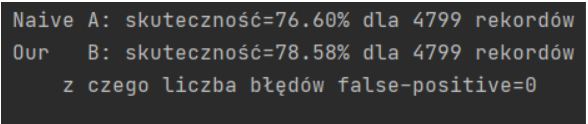
- Pomimo mniej skomplikowanej struktury modelu oraz mniejszej informatywności atrybutów wejściowych jest to najlepszy uzykany wynik.
- Warto zauważyć, że liczba błędów typu 'false-positive' jest równa zero - bardzo pozytywna cecha, dzięki której możemy przypuszczać, że rzeczywiste wprowazdenie modelu na środowisko produkcyjne przyniesie zauważalnąy dla przedsiębiorstwa wzrost w przychodach.
- Równa liczba rekordów wynika z faktu, że podczas 'karmienia' logów modelu sekwencyjnie zwiększaliśmy ID użytkownika przy każdym zapytaniu zamiast pobierać je z plików. Wg nas nie jest to błąd, ze względu na to, że wykorzystywaliśmy dane offline zamist online - następny eksperyment zasymulowaliśmy w sposób zgodny 'ze sztuką'.
---

`Naiwny i złożony`
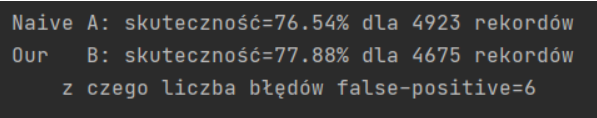
- Model wykorzystujący wszystkie wyselekcjonowane atrybuty
- liczba błędów 'false-positive' nie jest zerowa, ale dalej mała wzgledem liczby wszystkich zapytń

## Aplikacja

##### Opis aplikacji
Prosta aplikacja, umożliwiająca serwowanie predykcji oraz przeprowadzenie powyższych eksperymentów AB. Udostępnia dwa endpointy:
- `GET {url}/predict` - przyjmuje na wejściu wszystkie potrzebne modelom atrybuty, `user_id` w celu przydzielenia zapytania do odpowiedniego modelu oras `session_id` w celu późniejszego dopasowania. Parzyste do jednego, nieparzyste do drugiego. Zwraca odpowiedź binarną w formie `{"prediction": "False"}`
- `POST {url}/session_result` - przyjmuje na wejściu informacje o sukcesie lub jego braku danej sesji. Nie zwraca żadnej przydatnej informacji.

Pod spodem aplikacja loguje każde przychodzące zapytanie:
- `Prediction: <model> <session_id> <prediction>`
- `Result: <session_id> <result>`

Przykład zapytania:
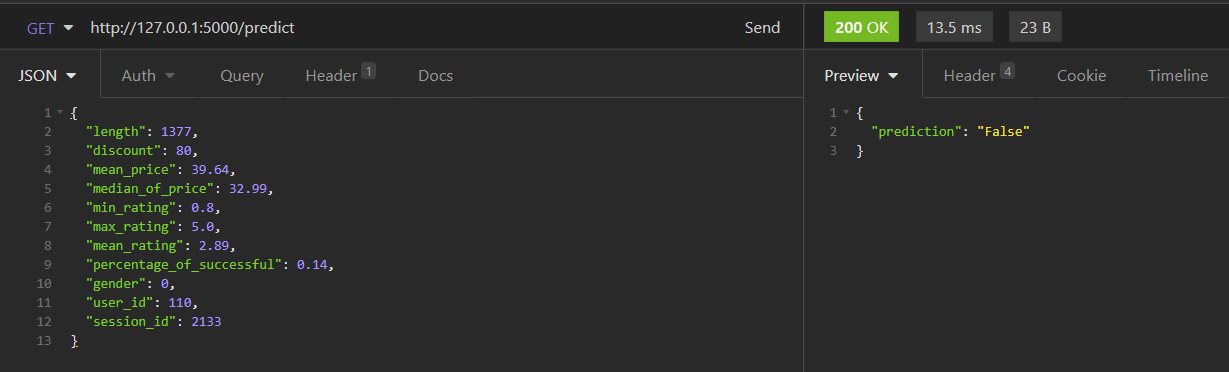

Analiza logów polega na:
1. odczytaniu ich
1. odsianiu logów niezwiązanych z eksperymentem
1. rozdzieleniu predykcji od właściwych rezultatów
1. dopasowaniu wierszy względem `<session_id>`
1. policzeniu poprawnych predykcji dla danych modeli


### 